In [38]:
import json
import numpy as np
import random
from gensim.models import KeyedVectors

In [39]:
# Load model
model = KeyedVectors.load("cc.ko.300.kv")

# Load word list
with open("korean_frequency.json", encoding="utf-8") as f:
    data = json.load(f)
word_list = sorted({w for group in data.values() for w in group})

In [40]:
# Similarity cache
similarity_cache = {}

def get_similarity(a, b):
    key = tuple(sorted((a, b)))
    if key in similarity_cache:
        return similarity_cache[key]
    if a not in model or b not in model:
        return 0
    sim = model.similarity(a, b) * 100
    similarity_cache[key] = sim
    return sim

In [41]:
# Update candidates with cache and consistency check
def update_candidates(candidates, guess, similarity, tried, tolerance=5.0):
    new_candidates = []
    for cand in candidates:
        if cand not in model:
            continue
        sim_to_guess = get_similarity(cand, guess)
        if abs(sim_to_guess - similarity) > tolerance:
            continue
        consistent = all(
            abs(get_similarity(cand, prev) - get_similarity(guess, prev)) <= tolerance
            for prev in tried[-3:] if prev in model
        )
        if consistent:
            new_candidates.append(cand)
    return new_candidates

# Select best guess based on standard deviation of similarities to remaining words
def select_best_guess(candidates, tried, remaining):
    best_score = -1
    best_word = None
    for word in candidates:
        if word in tried or word not in model:
            continue
        sims = [get_similarity(word, other) for other in remaining if other in model]
        if not sims:
            continue
        score = np.std(sims)
        if score > best_score:
            best_score = score
            best_word = word
    return best_word or random.choice(candidates)

In [35]:
# updating candidates
def update_candidates(candidates, guess, similarity, tried, tolerance=5.0):
    new_candidates = []
    for cand in candidates:
        if cand not in model:
            continue
        sim_to_guess = model.similarity(cand, guess) * 100
        if abs(sim_to_guess - similarity) > tolerance:
            continue
        # 이전 추측들과의 관계도 유사하게 유지되는지 확인
        consistent = all(
            abs(model.similarity(cand, prev) * 100 - model.similarity(guess, prev) * 100) <= tolerance
            for prev in tried[-3:]
            if prev in model
        )
        if consistent:
            new_candidates.append(cand)
    return new_candidates
  
# selecting best
def select_best_guess(candidates, tried, remaining):
    if not candidates:
        return None  # 예외 처리

    best_score = -1
    best_word = None
    for word in candidates:
        if word in tried or word not in model:
            continue
        sims = [model.similarity(word, other) for other in remaining if other in model]
        if not sims:
            continue
        score = np.std(sims)
        if score > best_score:
            best_score = score
            best_word = word

    # candidates가 존재하지만 valid candidate가 없을 경우
    return best_word if best_word else random.choice(candidates)

In [42]:
# Simulate one game
def simulate_game(answer):
    candidates = [w for w in word_list if w in model]
    remaining = candidates[:]
    tried = []
    for step in range(1, 21):
        guess = select_best_guess(remaining, tried, remaining)
        tried.append(guess)

        if guess == answer:
            print(f"✅ 정답 '{guess}'을 {step}번 만에 맞췄습니다!")
            return tried

        similarity = get_similarity(guess, answer)
        print(f"{step}. '{guess}' → 유사도: {similarity:.2f}")
        candidates = update_candidates(candidates, guess, similarity, tried)
        remaining = candidates[:]

    print("❌ 실패: 20회 이내에 정답을 찾지 못했습니다.")
    return tried


In [43]:
simulate_game("사랑스럽다")

1. '삶다' → 유사도: 10.96


IndexError: list index out of range

In [20]:
# 전체 성능 평가
def evaluate_model(sample_size=30):
    valid_words = [w for w in word_list if w in model]
    sampled_answers = random.sample(valid_words, sample_size)

    results = []
    for ans in sampled_answers:
        tried = simulate_game(ans)
        found = tried[-1] == ans
        results.append({
            'answer': ans,
            'steps': len(tried),
            'success': found
        })

    return pd.DataFrame(results)

1. '그러면' → 유사도: 3.55
2. '손잡다' → 유사도: 11.84
3. '널리' → 유사도: 13.02
4. '시야' → 유사도: 13.50
5. '규칙' → 유사도: 14.54
6. '이론적' → 유사도: 8.58
7. '볼펜' → 유사도: 21.82
8. '박사' → 유사도: 14.98
9. '상처' → 유사도: 17.86
10. '전시' → 유사도: 16.24
11. '상대' → 유사도: 28.60
12. '호흡' → 유사도: 13.24
✅ 정답 '미혼'을 13번 만에 맞췄습니다!
1. '친구' → 유사도: 24.22
2. '터널' → 유사도: 14.60
3. '자세' → 유사도: 14.03
4. '어린이' → 유사도: 12.03
5. '창구' → 유사도: 21.26
6. '공동' → 유사도: 17.37
7. '사용자' → 유사도: 9.43
8. '설탕' → 유사도: 27.44
✅ 정답 '해물'을 9번 만에 맞췄습니다!
1. '차마' → 유사도: 15.09
2. '포근하다' → 유사도: 10.78
3. '무려' → 유사도: 11.10
4. '외부' → 유사도: -4.45
5. '뛰어넘다' → 유사도: 33.49
✅ 정답 '비교하다'을 6번 만에 맞췄습니다!
1. '봉사' → 유사도: 15.77
2. '엄숙하다' → 유사도: 5.53
3. '태아' → 유사도: 21.22
4. '보도되다' → 유사도: 12.38
5. '제도적' → 유사도: 19.54
6. '구역' → 유사도: 21.46
7. '친척' → 유사도: 18.53
8. '흔적' → 유사도: 11.09
✅ 정답 '대중'을 9번 만에 맞췄습니다!
1. '세수' → 유사도: 28.45
2. '직원' → 유사도: 19.02
3. '아까' → 유사도: 14.66
4. '진통' → 유사도: 18.81
5. '외제' → 유사도: 29.28
6. '전통' → 유사도: 26.13
7. '가격' → 유사도: 16.10
8. '시골' → 유사도: 24.99
✅ 정답 '빨래'을 9번 만에 맞췄습니다!
1. 

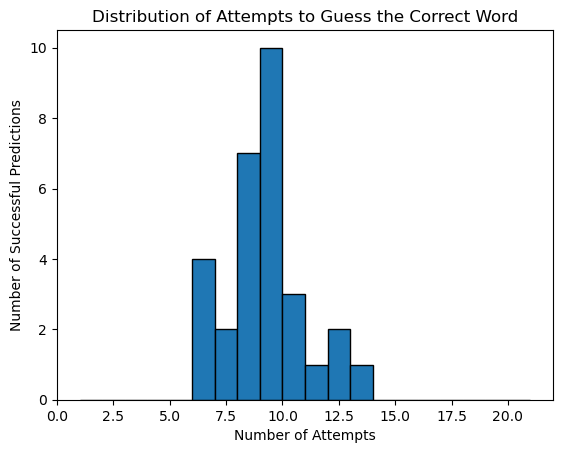

Average Number of Attempts: 8.73
Success Rate: 100.0%


In [23]:
# 평가 및 시각화
df = evaluate_model(30)

plt.figure()
plt.hist(df['steps'], bins=range(1, 22), edgecolor='black')
plt.xlabel("Number of Attempts")
plt.ylabel("Number of Successful Predictions")
plt.title("Distribution of Attempts to Guess the Correct Word")
plt.show()

avg_steps = df['steps'].mean()
success_rate = df['success'].mean() * 100
print(f"Average Number of Attempts: {avg_steps:.2f}")
print(f"Success Rate: {success_rate:.1f}%")
